In [0]:
import sys
sys.version

%reset -f
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
import sys
sys.version

!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
!pip3 install torchvision
!pip install 'livelossplot==0.2.2'
!pip install 'imageio==2.4.1'

print('done')
# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(0)

    100% |████████████████████████████████| 484.0MB 34kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b756000 @  0x7f95d4e602a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 12.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 47.4MB/s 


In [1]:
from torch.utils.data import Dataset
from skimage import io, transform
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import random 
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
# from scipy.misc import imread 
from imageio import imread
import torch
from livelossplot import PlotLosses
from torch.utils.data import Dataset, DataLoader


Using TensorFlow backend.


In [2]:

print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))

DATA_FOLDER ='data'

SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)

__pyTorch VERSION: 0.4.0
use_cuda = True


In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"66ec1c1397fd5cb0a1d4831d60f20a90"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/
#!sudo  rm ~/.kaggle/kaggle.json




kaggle.json


In [5]:
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset

100% 1.59G/1.59G [00:42<00:00, 30.1MB/s]
100% 1.59G/1.59G [00:42<00:00, 39.9MB/s]


In [0]:

!unzip -q v2-plant-seedlings-dataset.zip -d data

In [7]:
!ls data

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherd’s Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
class DatasetLoader(Dataset):

    def __init__(self, df, transform):
        self._df = df
        self._transform = transform


    @staticmethod
    def find_classes(root_dir):

        labels_folders = os.listdir(root_dir)
        index_class = {}
        xs = []
        ys = []

        for index, label in enumerate(labels_folders):
            index_class[index] = label
            y_train_folder = os.path.join(root_dir, label)
            for file in os.listdir(y_train_folder):
                train_example_path = os.path.join(y_train_folder, file)
                xs.append([train_example_path, label, index])
                ys.append(index)

        df = pd.DataFrame(xs, columns=['file', 'category', 'category_id'])

        return  index_class, df


    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        current_element = self._df.iloc[idx]
        fullname = current_element['file']

        image = Image.open(fullname).convert('RGB')

        if self._transform:
            image = self._transform(image)

        label = current_element['category_id']

        return image, label

In [9]:
index_class, data_df = DatasetLoader.find_classes(DATA_FOLDER)
all_data = data_df.sample(frac=0.90)
test_data = data_df[~data_df['file'].isin(all_data['file'])]
train_data = all_data.sample(frac=0.80)
valid_data = all_data[~all_data['file'].isin(train_data['file'])]
print('trainning size  {0} validation size {1} test size {2}'.format(len(train_data),len(valid_data),len(test_data)))

trainning size  3988 validation size 997 test size 554


In [15]:

train_data_transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor()
    ])


train_set = DatasetLoader(train_data, train_data_transform)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=0)


dataiter = iter(train_loader)

images, labels = next(dataiter)

images[0].shape


#train_data = data_df 

# from imageio import imread

# r_chanel = 0.0
# g_chanel = 0.0
# b_chanel = 0.0


# size = 0.0
# for index, row in train_data.iterrows():
#     image_path = row['file']

#     img = imread(image_path)

#     size += img.shape[0] * img.shape[1]
#     r_chanel += np.sum(img[:,:, 0])
#     g_chanel += np.sum(img[:, :, 1])
#     b_chanel += np.sum(img[:, :, 2])

# r_mean = r_chanel /size
# g_mean = g_chanel /size
# b_mean = b_chanel /size

# mean_calc_r = 0.0
# mean_calc_g = 0.0
# mean_calc_b = 0.0

# for index, row in train_data.iterrows():
#     img = imread(image_path)

#     mean_calc_r += np.sum(np.sqrt(np.square(img[:, :, 0] - r_mean)))
#     mean_calc_g += np.sum(np.sqrt(np.square(img[:, :, 1] - g_mean)))
#     mean_calc_b += np.sum(np.sqrt(np.square(img[:, :, 2] - b_mean)))


# std_r = mean_calc_r/(size-1)
# std_g = mean_calc_g/(size-1)
# std_b = mean_calc_b/(size-1)

# mean_rgb=[0.485, 0.456, 0.406]
# std_rgb=[0.229, 0.224, 0.225]

# mean_rgb = [r_mean, g_mean, mean_calc_b]
# std_rgb = [std_r, std_g, std_b]

tensor([[[ 0.3059,  0.3020,  0.3333,  ...,  0.3529,  0.3333,  0.3333],
         [ 0.3020,  0.3176,  0.3490,  ...,  0.3529,  0.3333,  0.3255],
         [ 0.2863,  0.3098,  0.3373,  ...,  0.3451,  0.3373,  0.3373],
         ...,
         [ 0.4706,  0.4941,  0.4588,  ...,  0.3843,  0.4000,  0.4039],
         [ 0.4471,  0.4588,  0.4392,  ...,  0.3765,  0.3843,  0.3882],
         [ 0.4235,  0.4157,  0.4196,  ...,  0.3843,  0.3882,  0.3843]],

        [[ 0.2353,  0.2275,  0.2588,  ...,  0.4000,  0.3804,  0.3765],
         [ 0.2314,  0.2471,  0.2745,  ...,  0.4000,  0.3765,  0.3686],
         [ 0.2235,  0.2471,  0.2706,  ...,  0.3922,  0.3804,  0.3843],
         ...,
         [ 0.3686,  0.3843,  0.3765,  ...,  0.2275,  0.2431,  0.2471],
         [ 0.3529,  0.3529,  0.3490,  ...,  0.2235,  0.2196,  0.2196],
         [ 0.3373,  0.3216,  0.3373,  ...,  0.2275,  0.2196,  0.2118]],

        [[ 0.1804,  0.1490,  0.1608,  ...,  0.2588,  0.2157,  0.1961],
         [ 0.1686,  0.1686,  0.1804,  ...,  0

In [17]:
images.shape

torch.Size([1, 3, 224, 224])

In [0]:
mean_rgb,std_rgb


(array([2.16657366e+10, 2.19300351e+10, 2.19300351e+10]),
 array([25.69838015, 26.01187261, 25.15464346]))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


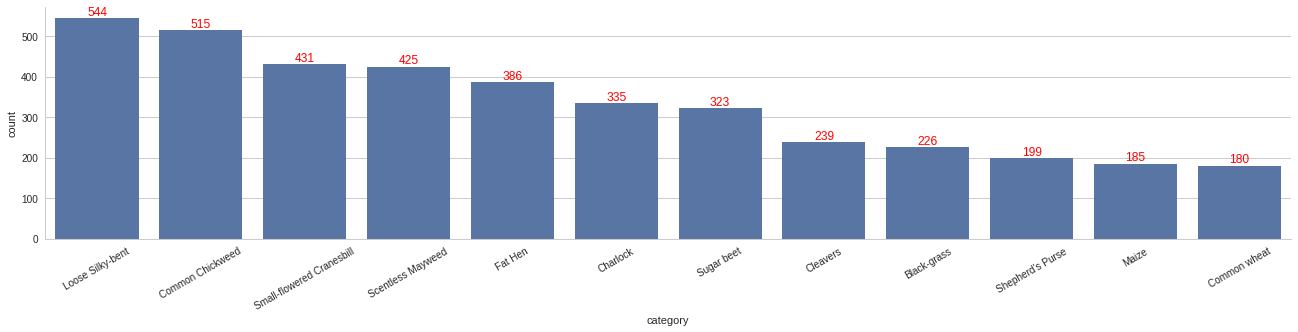

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

g = sns.factorplot("category", data=train_data, aspect=4.5, kind="count", color="b", order = train_data['category'].value_counts().index)
g.set_xticklabels(rotation=30)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')




/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


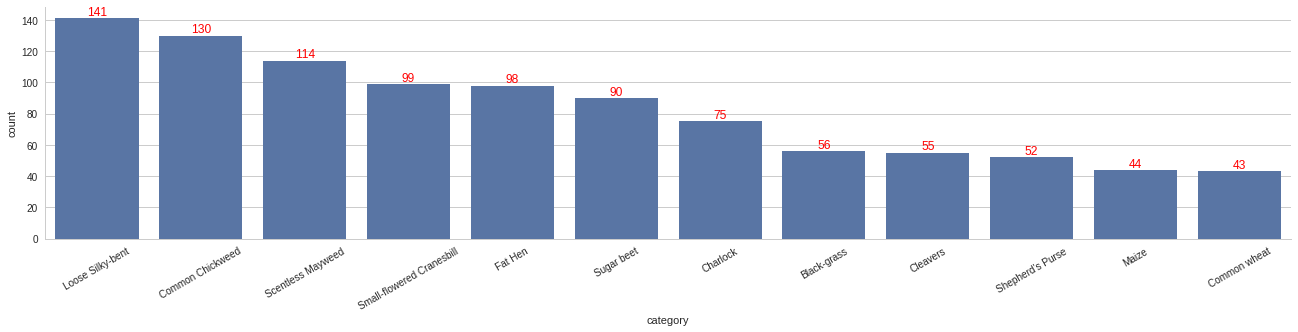

In [0]:
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

g = sns.factorplot("category", data=valid_data, aspect=4.5, kind="count", color="b",  order = valid_data['category'].value_counts().index)
g.set_xticklabels(rotation=30)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')



In [0]:
class NetA(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetA, self).__init__()  # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()  # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size,
                             num_classes)  # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)

    def forward(self, x):  # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
            

class LeNet(nn.Module):
    def __init__(self, num_classes=12, num_rgb=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(num_rgb, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        # print(out.data.size())
        n1 = self.num_flat_features(out)
        out = out.view(-1, n1)
        #out = out.view(n1, -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        
        
#         out = out.view(out.size(0), -1)
        # print(out.data.size())
        out = self.fc3(out)
        #todo: remove!!!!
        #out = self.sig(out)
        return out
    
    def num_flat_features(self, x):
      size = x.size()[1:]
      num_features = 1
      for s in size:
        num_features *= s
      return num_features
      

In [0]:
from torch.utils.data import Dataset, DataLoader

hidden_size = 500  
num_classes = 12  
num_epochs = 100  
momentum = 0.9
batch_size = 8 
learning_rate = 0.001
image_size = 224
input_size = image_size * image_size * 3 


print([mean_calc_r, mean_calc_g, mean_calc_g])
print([std_r, std_g, std_b])



normalize_img = transforms.Normalize(mean=[mean_calc_r, mean_calc_g, mean_calc_g],
                                     std=[std_r, std_g, std_b])


train_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
	
  
valid_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
	
  
test_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
	


# train_data_transform = transforms.Compose([
#     transforms.Resize(size=(image_size,image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (1.0,))
#     ])


# valid_data_transform = transforms.Compose([
#     transforms.Resize(size=(image_size,image_size)),
#     transforms.ToTensor(), 
#     transforms.Normalize((0.5,), (1.0,))
#      #normalize_img
#     ])

# test_data_transform = transforms.Compose([
#     transforms.Resize(size=(image_size,image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (1.0,))
#     #normalize_img
#     ])


train_set = DatasetLoader(train_data, train_data_transform)
valid_set = DatasetLoader(valid_data, valid_data_transform)
test_set = DatasetLoader(test_data, test_data_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)


# print(num_classes)
# print(input_size)
# len(train_data)


[21665736572.661148, 21930035143.34442, 21930035143.34442]
[25.698380146216746, 26.01187261016976, 25.154643464997505]


In [0]:

import matplotlib.pyplot as plt
import numpy as np
import torchvision


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    

dataiter = iter(train_loader)
 
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

      

ValueError: ignored

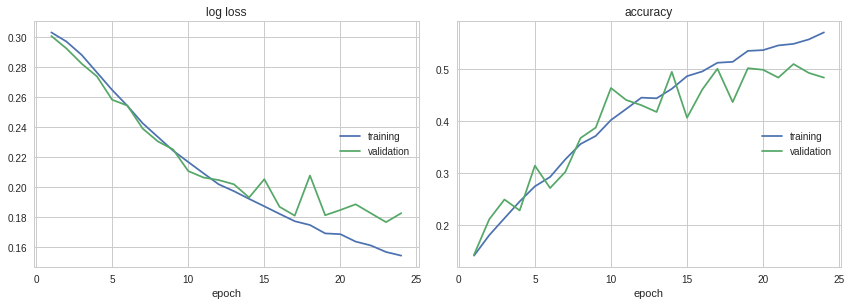

log loss:
training   (min:    0.155, max:    0.303, cur:    0.155)
validation (min:    0.177, max:    0.300, cur:    0.183)

accuracy:
training   (min:    0.141, max:    0.570, cur:    0.570)
validation (min:    0.142, max:    0.510, cur:    0.483)


KeyboardInterrupt: ignored

In [0]:

liveloss = PlotLosses()


neta = NetA(input_size, hidden_size, num_classes)


print(neta)
if use_cuda:
    print('use coda')
    model = neta.cuda()
else:
    print('dont use coda')
    model = neta

model = torch.nn.DataParallel(model, device_ids=list(range(1)))    

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

if use_cuda:
  criterion.cuda()

print('use_cuda {0}'.format(use_cuda))
model.train()
print('b1')

for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    epoch_correct = 0.0
    epoch_incorrect = 0.0
    epoch_loss_val = 0.0
    epoch_correct_val = 0.0
    avg_loss_val = 0.0
    avg_accuracy_val = 0.0
    model.train()
    total = 0.0
    correct = 0.0
    for i, (images, labels) in enumerate(train_loader):  # Load a batch of images with its (index, data, class)
       
        if use_cuda and torch.cuda.is_available():
            images = images.view(-1, image_size * image_size * 3).cuda()
            labels = labels.cuda()
            images = Variable(images)  
            labels = Variable(labels)
        else:
          images = Variable(images.view(-1, image_size * image_size * 3))  
          labels = Variable(labels)
        
        optimizer.zero_grad()    
        
        outputs = model(images)  
        loss = criterion(outputs, labels)
        
        
        loss.backward() 
        optimizer.step()
                
        total += len(images)
        
        epoch_loss += loss.data[0]
        current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        epoch_incorrect += current_incorrect
        pred = outputs.data.max(1)[1] 
        correct += pred.eq(labels.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        epoch_correct += current_correct
        
    avg_loss = epoch_loss / len(train_loader.dataset)
    avg_accuracy = epoch_correct / (len(train_loader.dataset)*1.0)
    

    
    model.eval()
    for inputs, labels in validation_loader:
                
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.view(-1, image_size * image_size * 3).cuda()
            labels = labels.cuda()
            inputs = Variable(inputs)  
            labels = Variable(labels)
        else:
          inputs, labels = Variable(inputs.view(-1, image_size * image_size * 3)) , Variable(labels)
        
   
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        
        epoch_loss_val += loss.data[0]
        
        
        epoch_correct_val += (outputs.cpu().data.max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    
    #print('epoch_correct_val = {0}'.format(epoch_correct_val))
    
    avg_loss_val = epoch_loss_val / len(validation_loader.dataset)
    avg_accuracy_val = epoch_correct_val / len(validation_loader.dataset)
    
    #print('avg_accuracy_val = {0}'.format(avg_accuracy_val))
    
    liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    
    liveloss.draw()
    
    
        

In [0]:
def train(model, device, train_loader, optimizer, criterion):
  print(1)
  model.train()
  
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
    
  for i, (images, labels) in enumerate(train_loader):
    
    images = images.view(-1, image_size * image_size * 3).to(device)
    #images = images.to(device)
    labels = labels.to(device)
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad()    
    outputs = model(images)  
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    total += len(images)
    epoch_loss += loss.data[0]
    current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    epoch_incorrect += current_incorrect
    pred = outputs.data.max(1)[1] 
    correct += pred.eq(labels.data).cpu().sum()
    accuracy = 100. * correct / len(images)
    epoch_correct += current_correct
        
        
  avg_loss = epoch_loss / len(train_loader.dataset)
  avg_accuracy = epoch_correct / (len(train_loader.dataset)*1.0)
  print('train')
  return avg_loss, avg_accuracy


In [0]:
def test(model, device, loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  
  with torch.no_grad():
    
    for inputs, labels in loader:
        
        
        inputs = inputs.view(-1, image_size * image_size * 3).to(device)
        labels = labels.to(device)
        inputs = Variable(inputs)  
        labels = Variable(labels)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val += loss.data[0]
        epoch_correct_val += (outputs.cpu().data.max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        
  avg_loss_val = epoch_loss_val / len(loader.dataset)
  avg_accuracy_val = epoch_correct_val / len(loader.dataset)
  
  return avg_loss_val,avg_accuracy_val
    

                                                                                              
                                                                                              
                                                                                              

In [0]:
device = torch.device("cuda" if use_cuda else "cpu")

liveloss = PlotLosses()

model = NetA(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
# criterion.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(num_epochs):

  avg_loss, avg_accuracy = train(model, device, train_loader, optimizer, criterion)
  avg_loss_val,avg_accuracy_val = test(model, device, validation_loader, criterion)
  
  liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    
    
  liveloss.draw()
    
  

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


KeyboardInterrupt: ignored

In [0]:
import torch.nn.functional as F
def train_conv(model, device, current_loader, optimizer, criterion):
  print(1)
  model.train()
  
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
    
  for i, (images, labels) in enumerate(current_loader):
    
    #images = images.view(-1, image_size * image_size * 3).to(device)
    images = images.to(device)
    labels = labels.to(device)
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad()    
    outputs = model(images)  
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    total += len(images)
    #epoch_loss += loss.data.cpu().numpy().item()
    #print('loss.data = {0}'.format(loss.data[0].to(torch.device("cpu")).numpy().item()))
    epoch_loss += loss.data[0].to(torch.device("cpu")).numpy().item()
    #print(epoch_loss)
    
    #current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().item()
    current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().item()
    #print('F={0}'.format(F.nll_loss(outputs, labels, reduction='sum').item()))
    if i %10 == 0:
      print('correct {0} current_incorrect ={1}'.format(current_correct, current_incorrect))
    #current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    epoch_incorrect += current_incorrect
    pred = outputs.data.max(1)[1] 
    correct += pred.eq(labels.data).cpu().sum()
    accuracy = 100. * correct / len(images)
    epoch_correct += current_correct
        
  print(epoch_loss)      
  avg_loss = epoch_loss / len(current_loader.dataset)
  print(avg_loss)
  avg_accuracy = epoch_correct / (len(current_loader.dataset)*1.0)
  print('train')
  print(avg_accuracy)
  return avg_loss, avg_accuracy

In [0]:
def test_conv(model, device, loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  
  with torch.no_grad():
    
    for inputs, labels in loader:
        
        
#         inputs = inputs.view(-1, image_size * image_size * 3).to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = Variable(inputs)  
        labels = Variable(labels)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val += loss.data[0].to(torch.device("cpu")).numpy().item()
        #epoch_correct_val += (outputs.cpu().data.max(1)[1] == labels.data.cpu()).sum().item()
        epoch_correct_val +=  (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().item()
        
  avg_loss_val = epoch_loss_val / len(loader.dataset)
  avg_accuracy_val = epoch_correct_val / len(loader.dataset)
  
  return avg_loss_val,avg_accuracy_val
    

In [0]:
device = torch.device("cuda" if use_cuda else "cpu")

liveloss = PlotLosses()
model = LeNet(12, 3).to(device)
#model = NetB().to(device)
criterion = nn.CrossEntropyLoss().to(device)
#nn.CrossEntropyLoss()
# criterion.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(num_epochs):

  avg_loss, avg_accuracy = train_conv(model, device, train_loader, optimizer, criterion)
  avg_loss_val,avg_accuracy_val = test_conv(model, device, validation_loader, criterion)
  
  liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    
    
  liveloss.draw()

1
correct 1 current_incorrect =7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


correct 2 current_incorrect =6
correct 0 current_incorrect =8
correct 1 current_incorrect =7
correct 0 current_incorrect =8
correct 0 current_incorrect =8
correct 1 current_incorrect =7
correct 0 current_incorrect =8
correct 0 current_incorrect =8
correct 3 current_incorrect =5
correct 1 current_incorrect =7
correct 1 current_incorrect =7
correct 0 current_incorrect =8
correct 2 current_incorrect =6
correct 3 current_incorrect =5
correct 2 current_incorrect =6
correct 2 current_incorrect =6
correct 1 current_incorrect =7


KeyboardInterrupt: ignored

In [0]:
model = LeNet()
model = model.cuda()
#criterion = nn.CrossEntropyLoss().cude()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
  
  running_loss = 0.01
  calc_correct = 0.0
  calc_count = 0.0
  
  for i, (images, labels) in enumerate(train_loader):
#     images = images.view(-1, image_size * image_size * 3).cuda()
    #images = images.unsqueeze(1)
    images = images.cuda()
    labels = labels.cuda()
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad() 
    outputs = model(images)  
    _, pred = torch.max(outputs.data, 1)
    calc_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
#     print(calc_correct)
    calc_count+=outputs.data.shape[0]
    
    
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    
    running_loss += loss.item()
    if i % 200 == 0:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
    
    #if (i + 1) % 20 == 0:
      #print("Epoch = %d, Loss = %f" %(epoch, loss.data[0]))
      #current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().item()
      #current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().item()
      #print('correct {0} current_incorrect ={1}'.format(current_correct, current_incorrect))
      
  pred = outputs.data.max(1)[1] # get the index of the max log-probability
  correct += pred.eq(labels.data).cpu().sum()
  accuracy = 100. * correct / len(images)
  
  print('calc_correct/calc_count = {0} -> calc_correct={1} calc_count={2}'.format(calc_correct/calc_count, calc_correct, calc_count))
  
  print('accuracy = {0}'.format(accuracy))
    


[1,     1] loss: 0.001
[1,   201] loss: 0.245
[1,   401] loss: 0.242
calc_correct/calc_count = 0.14969909729187564 -> calc_correct=597.0 calc_count=3988.0
accuracy = 25
[2,     1] loss: 0.001
[2,   201] loss: 0.215
[2,   401] loss: 0.181
calc_correct/calc_count = 0.3257271815446339 -> calc_correct=1299.0 calc_count=3988.0
accuracy = 50
[3,     1] loss: 0.001
[3,   201] loss: 0.156
[3,   401] loss: 0.155
calc_correct/calc_count = 0.44007021063189566 -> calc_correct=1755.0 calc_count=3988.0
accuracy = 25
[4,     1] loss: 0.001
[4,   201] loss: 0.139
[4,   401] loss: 0.141
calc_correct/calc_count = 0.5045135406218656 -> calc_correct=2012.0 calc_count=3988.0
accuracy = 25
[5,     1] loss: 0.001
[5,   201] loss: 0.117
[5,   401] loss: 0.116
calc_correct/calc_count = 0.5882647943831495 -> calc_correct=2346.0 calc_count=3988.0
accuracy = 50
[6,     1] loss: 0.001
[6,   201] loss: 0.105
[6,   401] loss: 0.098
calc_correct/calc_count = 0.6421765295887663 -> calc_correct=2561.0 calc_count=3988.0

KeyboardInterrupt: ignored